# Linear Gaussian systems (Chapter 3)

This notebook covers the code and explanation for the following experiments in Chapter 3 of the textbook "Fundamentals of Active Inference":
* Experiment 3F
* Experiment 3G

==========================================================================
* **Author**: Sanjeev Namjoshi (sanjeev.namjoshi@gmail.com)

* **Version**: 0.1

*This Jupyter notebook should only be distributed to members of the "Fundamentals of Active Inference" reading group hosted by the Active Inference Institute.*

Package versions:
* matplotlib==3.5.3
* numpy==1.21.5
* pyro-ppl==1.8.4
* pytorch==1.13.1
* scipy==1.7.3

In [1]:
import matplotlib.pyplot as plt
import matplotlib as mpl
import numpy as np
import torch

from pyro.distributions import MultivariateNormal
from scipy.stats import zscore

plt.rcParams.update({
    "text.usetex": True,
    "figure.dpi": 120})

mpl.style.use("seaborn-deep")

## Experimenting with the mixing matrix

In the text we explored the linear Gaussian system (LGS), a unifying model that can be used for unsupervised learning techniques where we have an unobserved variables $\boldsymbol{x}$ whose value we wish to obtain through just an observed $\boldsymbol{y}$. We can think of this as the multivariate extension of the hidden state estimation problem from Chapter 2. In many LGS problems we have the following set up:

| Variable | Status     | Data type     |
|----------|------------|---------------|
| $x$      | unobserved | probabilistic |
| $y$      | observed   | probabilistic |
| $\Theta$ | observed   | deterministic |
| $\phi$   | known      | deterministic |

In other problems, we will see that $\Theta$ and $\phi$ may also be unobserved. The LGS acts by combining noisy samples of a vector $\boldsymbol{x}_i$ with a mixing matrix $\boldsymbol{\Theta}$ plus and offset $\boldsymbol{b}$ and noise to produce samples of $\boldsymbol{y}_i$:

$$
\boldsymbol{y}_i = \boldsymbol{\Theta} \boldsymbol{x}_i + \boldsymbol{b}.
$$

The mixing matrix "mixes" combinations of the elements of $\boldsymbol{x}$ in different proportions to produce the different elements of $\boldsymbol{y}$. Each row in the mixing matrix specifies how the proportions $\boldsymbol{x}$ will mix for that element of $\boldsymbol{y}$. The results a just a consequence of the definition of *matrix multiplication*.

To get a feel for how the mixing matrix works, experiment with different inputs to see what their outputs look like. Below are the variables used in the text.

In [2]:
Theta = np.array([[1, -4, 2],
                  [3, 6, -7],
                  [-4, 0, 12],
                  [1, 6, 8]])

x = np.array([2, 3, 5])
b = np.array([0, 4, 8, -9])
y = Theta @ x + b

print("y = Theta @ x + b: \n")
print(f'Theta: \n {Theta}')
print(f'x: {x}')
print(f'b: {b}')
print(f'y: {y}')

y = Theta @ x + b: 

Theta: 
 [[ 1 -4  2]
 [ 3  6 -7]
 [-4  0 12]
 [ 1  6  8]]
x: [2 3 5]
b: [ 0  4  8 -9]
y: [ 0 -7 60 51]


## Experiment 3F: Inferring an unknown vector

Imagine that we have an agent located at the origin on a 2D grid. Somewhere on this grid is a food source that it wishes to get to. We define the states of the enviroment by the vector $\boldsymbol{x} \in \mathbb{R}^{p=2}$ which is composed of two elements defining the true position of the food in an $(x, y)$ coordinate pair. Let's suppose that the food itself is obscured by some grass so the agent is not able to determine the exact location of the food. The agent's goal is to take (noisy) samples of the food's position to locate where the food is. 

In this example, we will have no mixing matrix, $\boldsymbol{\Theta} = \boldsymbol{I}$, and no offset $\boldsymbol{b}$, which means that $\boldsymbol{x}$ is related to $\boldsymbol{y}$ purely through noise. This simple scenario will help us get a handle on the linear Gaussian system (LGS) so we can use it in more complex examples.

First, we set up the environment. The environment consists of a true state vector $\boldsymbol{x} = [0.4 \; 0.6]^T$ and $20$ noisy samples of this vector. This means that each time we sample the environment, the sample is a vector of dimension $p=2$. In this example, the output observation vector will have the same dimensions as $\boldsymbol{x}$ so $\boldsymbol{y} \in \mathbb{R}^{d=2=p}$.

In [3]:
def create_grid(x_min, x_max):
    X_grid, y_grid = np.mgrid[x_min:x_max:.001, x_min:x_max:.001]
    grid = np.dstack((X_grid, y_grid))
    return grid

In [4]:
""" ENVIRONMENT """
n     = 20                             # Number of samples of x
cov_y = torch.tensor([[0.7, 0.],       # Covariance matrix of y scaled by the number of samples
                     [0., 0.6]]) / n
x     = torch.tensor([0.4, 0.6])       # The true state vector x. Dimension [p x 1]

torch.manual_seed(432)
y     = MultivariateNormal(            # The observation vector y. DImension [d x 1]
            loc=x, 
            covariance_matrix=cov_y).sample([n])

Next, we need to create the parameters of the agent's model. We will assume that as a prior, the agent assumes that the food is at the position $(0.5, 0.5)$. In the last few hours, the food has rolled away from here so it is no longer in this location. However, since it has not moved far, this is a good assumption for the starting position of where the food might be that will help the agent constrain the space it has to search over. Thus, the prior distribution will have a mean of $\boldsymbol{\mu}_x = [0.5 \; 0.5]^T$. We will use a spherical covariance matrix of $\boldsymbol{\Sigma} = 0.5 \boldsymbol{I}$. We will also go ahead and pre-calculate the precision matrices since they show up freqeuently in the formulas.

Then, we calculate the mean and covariance matrix of the conditional distribution of $p(\boldsymbol{x} \mid \boldsymbol{y})$. We can do this with the following two equations:

$$
\begin{align}
    \boldsymbol{\Sigma}_{x \mid y} &= \left (\boldsymbol{\Sigma}_x^{-1} + n \boldsymbol{\Sigma}_y^{-1} \right )^{-1} \\
    \boldsymbol{\mu}_{x \mid y} &= \boldsymbol{\Sigma}_{x \mid y} \left (\boldsymbol{\Sigma}^{-1}_y (n \bar{\boldsymbol{y}}) + \boldsymbol{\Sigma}_x^{-1} \boldsymbol{\mu}_x \right )
\end{align}
$$

These equations directly follow from the mean and covariance matrix of the conditional distribution of a linear Gaussian system (see text for more details and Appendix C for derivation). Computing these equations in code is simple. One thing we will do to make things eaiser is go ahead an define the *precisions*, or inverse covariance matrices, for $\boldsymbol{x}$ and $\boldsymbol{y}$. This will make the code less messy. Then we compute the posterior mean and covariance matrix.

In [5]:
""" AGENT """   
# Prior parameters
mu_x  = torch.tensor([0.5, 0.5])   # Dimension [p x 1]
cov_x = 0.5 * torch.eye(2)         # Dimension [p x p]

# Precision (inverse variance)
pre_y = torch.linalg.inv(cov_y)    # Dimension [d x d]
pre_x = torch.linalg.inv(cov_x)    # Dimension [p x p]

# Posterior parameters
cov_p = torch.linalg.inv(pre_x + n * pre_y)
mu_p  = cov_p @ (pre_y @ (n * torch.mean(y, dim=0)) + pre_x @ mu_x)

Next, let's create our grid and calculate the posterior probabilities. This is done by passing the mean and covariance matrices we obtained for the posterior above into a multivariate normal so we can plot it. We then plot the figure. In the plot, a scatter plot of points is shown which are the noisy observations is saw. We can see that the agent uses these noisy observations to localize the mean of where they originated from which is quite close to the true position of the food (red cross). 

/tmp/ipykernel_7001/1933758640.py:7: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  posterior = MultivariateNormal(torch.tensor(mu_p.flatten()), torch.tensor(cov_p))


Text(0, 0.5, '$\\textrm{Vertical position}$')

<Figure size 768x576 with 0 Axes>

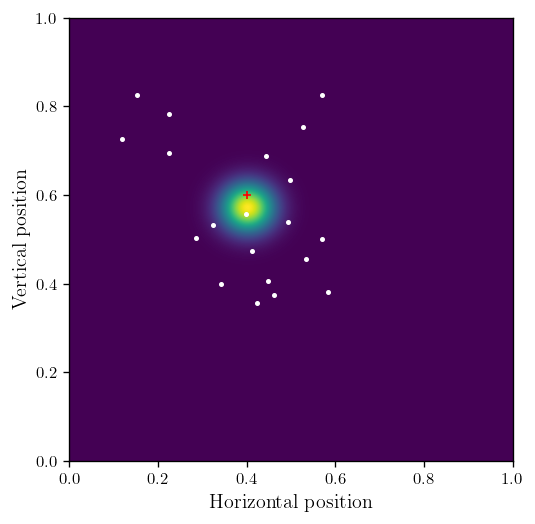

In [6]:
# Grid
x_min = 0
x_max = 1
grid = create_grid(x_min, x_max)

# Posterior probs
posterior = MultivariateNormal(torch.tensor(mu_p.flatten()), torch.tensor(cov_p))
posterior_log_probs = posterior.log_prob(torch.tensor(grid))
posterior_probs = np.exp(posterior_log_probs)

# Plot
fig = plt.figure()
fig, ax = plt.subplots(1,1, facecolor=(1,1,1))

## Distribution
ax.imshow(posterior_probs.t(), origin="lower", cmap="viridis", extent=[x_min, x_max, x_min, x_max])

## True x
ax.plot(x[0], x[1], marker="+", color="red", markersize=5)

## Samples
ax.scatter(y[:, 0].numpy(), y[:, 1].numpy(), s=4, color="white")
ax.set_xlabel(r"$\textrm{Horizontal position}$", fontsize=12)
ax.set_ylabel(r"$\textrm{Vertical position}$", fontsize=12)

The distribution itself is quite tightly centered near the true position which we can see is a result of the covariance matrix which has a fairly small variance along the diagonal: 

In [7]:
cov_p

tensor([[0.0017, 0.0000],
        [0.0000, 0.0015]])

## Experiment 3G: Factor analysis EM

In the final piece of this chapter we combine (multivariate) learning and inference together. Namely, we are interested in the following relationship among variables:

| Variable | Status     | Data type     |
|----------|------------|---------------|
| $x$      | unobserved | probabilistic |
| $y$      | observed   | probabilistic |
| $\Theta$ | unobserved | deterministic |
| $\phi$   | unobserved | deterministic |

Although for this example, the only unknown in $\phi$ will be the covariance matrix on $y$. This setup presents a problem. If everything is unknown how do we ever "get off the ground"? If $x$ is unobserved we can't perform inference because we don't know the parameters. But if we want to learn the parameters we cannot do that either because we have not yet observed $x$. The expectation maximization algorithm provides a way around this problem and is explained in much more detail in the text. The problem description is given in the text and copied directly here:

> For this experiment, consider an agent located at the origin of a grid that is trying to determine the 2D coordinates of a piece of food, similar to Experiment 3G. An agent, in position $[-0.5 \; 0.5]$, has just heard a rival conspecific kill a prey, located at the origin. The agent decides it wants to steal the food but unfortunately, cannot see where the rival and dead prey are. Meanwhile, the rival is prowling around the dead prey at the origin trying to find the agent. Every so often it stops for a moment. Consider these stopping coordinates $\boldsymbol{x}_i \in \mathbb{R}^2$ which is a 2-dimensional vector denoting the position of the rival on the grid. When the rival moves to and from the stop locations it rustles the grass and makes a sound. At this position, the combination of states interacts within the environment in such a way that various observations $\boldsymbol{y}_i \in \mathbb{R}^8$ can be detected by the agent. The eight elements within this vector may be thought of different types of physical quantities the agent can sense or measure such as light, sound, vibrations on the ground, and so on. Thus in this system, samples of a noisy state vector $\boldsymbol{x}_i$ interact with a mixing matrix $\boldsymbol{\Theta}$ to produce a noisy observation vector $\boldsymbol{y}_i$. 

> The agent's goal is to use the noisy observation vector to infer the area around which the rival is circling so it can steal its prey. However, the agent does not already know from prior learning how the states mix to form the observations ($\boldsymbol{\Theta}$ is unknown) nor does it know the noise in the generation of $\boldsymbol{y}_i$ ($\boldsymbol{\Sigma}_y$) is unknown. Thus, the agent's must learn these model parameters from the data alongside estimating the hidden state. To learn these model parameters, the agent will initialize with a random guess and then iteratively update using the EM algorithm. 


First, let's create our environment. We will need to construct a vector $\boldsymbol{x} \in \mathbb{R}^{p=2}$ which generates $\boldsymbol{y} \in \mathbb{R}^{d=2}$ through the linear model. We will use 100 samples in our example.

In [16]:
# Environment
p = 2    # Dimension of x
d = 8    # Dimension of y
n = 100  # Number of samples

# Grid
x_min = -3
x_max = 3
grid = create_grid(x_min, x_max)

According to the model, $\boldsymbol{x}_i \sim \mathcal{N}(\boldsymbol{0}, \boldsymbol{I})$. What does this look like on the grid?

Text(0, 0.5, '$\\textrm{Vertical position}$')

<Figure size 768x576 with 0 Axes>

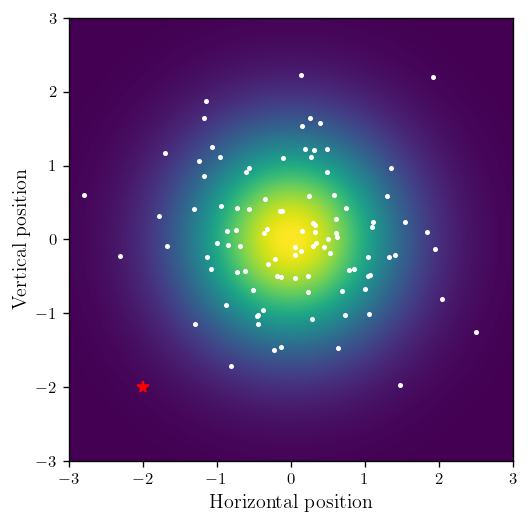

In [17]:
# p(x) - prior
torch.manual_seed(2345)
p_x = MultivariateNormal(loc=(torch.zeros(p)), covariance_matrix=torch.eye(p))
p_x_log_probs = p_x.log_prob(torch.tensor(grid))
p_x_probs = np.exp(p_x_log_probs)

# Plot
fig = plt.figure()
fig, ax = plt.subplots(1,1, facecolor=(1,1,1))

## Distribution
ax.imshow(p_x_probs.t(), origin="lower", cmap="viridis", extent=[x_min, x_max, x_min, x_max])

## Agent location
ax.plot(-2, -2, marker="*", color="red", markersize=7)

## Samples
torch.manual_seed(2345)
x_sample = MultivariateNormal(loc=(torch.zeros(p)), covariance_matrix=torch.eye(p)).sample([n]).numpy()
ax.scatter(x_sample[:, 0], x_sample[:, 1], s=4, c="white")

ax.set_xlabel(r"$\textrm{Horizontal position}$", fontsize=12)
ax.set_ylabel(r"$\textrm{Vertical position}$", fontsize=12)

Next we create the environment. Note that the environment uses a diagonal covariance matrix for the generation of $y$.

In [18]:
n             = 500                                                                        # Number of samples       
torch.manual_seed(3252)
x_true_dist   = MultivariateNormal(loc=(torch.zeros(p)), covariance_matrix=torch.eye(p))   # True state vector [p x n]
cov_y_true    = torch.rand(d) * torch.eye(d)                                               # True (diagonal) covariance matrix [d x d] 
epsilon_dist  = MultivariateNormal(loc=torch.zeros(d), covariance_matrix=cov_y_true)       # True y noise [d x 1]
Theta_true    = torch.rand(d, p)                                                           # True mixing matrix [d x p]  

# Use above to generate a sample of y according to y = Theta @ x + epsilon; center the data
def environment(Theta_true, x_true_dist, epsilon_dist):
    x_true = x_true_dist.sample()
    epsilon = epsilon_dist.sample()
    y = zscore(Theta_true @ x_true + epsilon)
    return x_true, y

# Run environment n times to fill up a tensor
Y = []
X = []
for _ in range(n):
    x_true, y = environment(Theta_true, x_true_dist, epsilon_dist)
    Y.append(y)
    X.append(x_true)
    
Y = torch.stack(Y, axis=1)   # Sensory data [d x n]
X = torch.stack(X, axis=1)   # States [p x n]

To perform the EM algorithm, we first need to randomly initialize the two unknown parameters, $\boldsymbol{\Theta}$ and $\boldsymbol{\Sigma}_y$. Then, over $100$ iterations we first perform the **E-step**:

$$
\begin{align}
    \boldsymbol{\mu}_{x \mid y}^{(t)} &\leftarrow \underbrace{\boldsymbol{\Theta}^T(\boldsymbol{\Theta} \boldsymbol{\Theta}^T + \boldsymbol{\Sigma}_y)^{-1}}_{\beta}\boldsymbol{Y} \\
    \boldsymbol{\Sigma}_{x \mid y}^{(t)} &\leftarrow \boldsymbol{I} - \beta \boldsymbol{\Theta},
\end{align}
$$

followed by the **M-step**:

$$
\begin{align}
    \boldsymbol{\Theta}^{(t+1)} &\leftarrow \underbrace{\boldsymbol{Y} \boldsymbol{\mu}_{x \mid y}^T}_{\delta} {\underbrace{(\boldsymbol{\mu}_{x \mid y} \boldsymbol{\mu}_{x \mid y}^T + n \boldsymbol{\Sigma}_{x \mid y})}_{\gamma}}^{-1} \\
    \boldsymbol{\Sigma}_y^{(t+1)} &\leftarrow diag(Cov(\boldsymbol{Y}) - \frac{\boldsymbol{\Theta} \delta^T}{n})
\end{align}
$$

These rules are implemented in the code below.

In [19]:
# Modeling setup
n_iterations = 100

# Initializations
Theta = torch.rand(d, p)               # Randomly initialize the mixing matrix [d x p]  
cov_y = torch.rand(d) * torch.eye(d)   # Randomly initialize the covariance matrix [d x d]

for i in range(n_iterations):
    
    S = torch.cov(Y)   # Compute the sample covariance
    
    """ E-step """
    # Inference of x_hat and cov_x
    beta = Theta.T @ torch.linalg.inv(Theta @ Theta.T + cov_y)
    x_hat = beta @ Y
    cov_x = torch.eye(p) - beta @ Theta
    
    """ M-step"""
    delta = Y @ x_hat.T
    gamma = x_hat @ x_hat.T + (n * cov_x)
    
    # Maximum likelihood updates for Theta and cov_y
    Theta = delta @ torch.linalg.inv(gamma)
    cov_y = torch.diag(torch.diag(S - (Theta @ delta.T / n)))   # Replace diagonal of cov_y with new diagonal

Finally, we use the latest parameter settings to compute the mean and covariance matrix so we can plot it.

Inferred mean: tensor([-0.0155,  0.0455])
Inferred covariance matrix: tensor([[0.1023, 0.0057],
        [0.0057, 0.1757]])


Text(0, 0.5, '$\\textrm{Vertical position}$')

<Figure size 768x576 with 0 Axes>

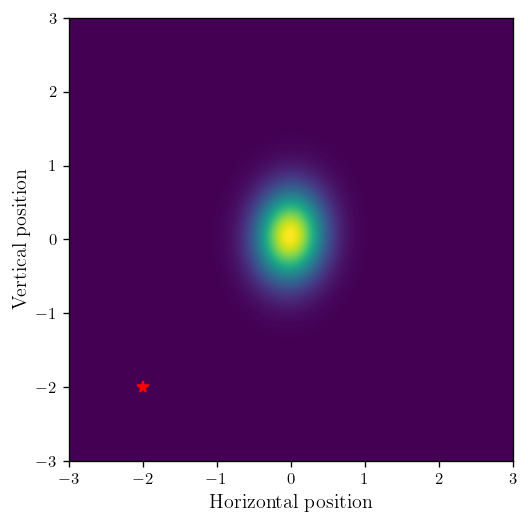

In [20]:
# Plot the belief about the true mean of x
mu_p = torch.mean(Theta.T @ torch.linalg.inv(Theta @ Theta.T + cov_y) @ Y, dim=1)
cov_p = torch.eye(p) - Theta.T @ torch.linalg.inv(Theta @ Theta.T + cov_y) @ Theta

print(f"Inferred mean: {mu_p}")
print(f"Inferred covariance matrix: {cov_p}")

""" Plot the inferred probability of x"""
# Grid
x_min = -3
x_max = 3
grid = create_grid(x_min, x_max)

# p(x)_hat - inferred posterior
p_x_hat = MultivariateNormal(loc=mu_p, covariance_matrix=cov_p)
p_x_hat_log_probs = p_x_hat.log_prob(torch.tensor(grid))
p_x_hat_probs = np.exp(p_x_hat_log_probs)

# Plot
fig = plt.figure()
fig, ax = plt.subplots(1,1, facecolor=(1,1,1))

## Distribution
ax.imshow(p_x_hat_probs.t(), origin="lower", cmap="viridis", extent=[x_min, x_max, x_min, x_max])

## Agent location
ax.plot(-2, -2, marker="*", color="red", markersize=7)

ax.set_xlabel(r"$\textrm{Horizontal position}$", fontsize=12)
ax.set_ylabel(r"$\textrm{Vertical position}$", fontsize=12)